In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

Chargement des datasets
'train.csv' contient les passagers avec leur survie
'test.csv' contient les passagers à prédire

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Exploration rapide pour comprendre la structure des données, les types de variables et les valeurs manquantes.
On regarde aussi la distribution des survivants et des variables clés.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

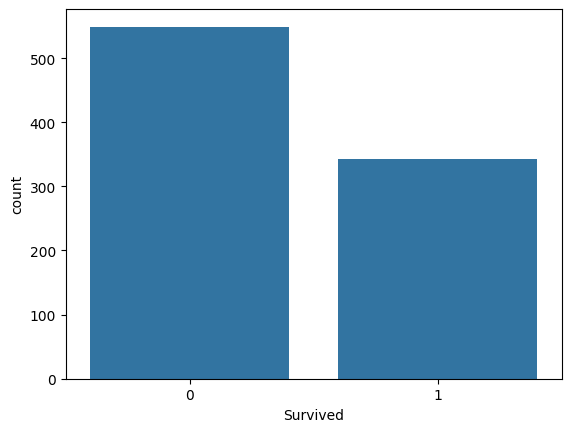

In [7]:
sns.countplot(x=train.Survived)

<Axes: xlabel='Age', ylabel='Count'>

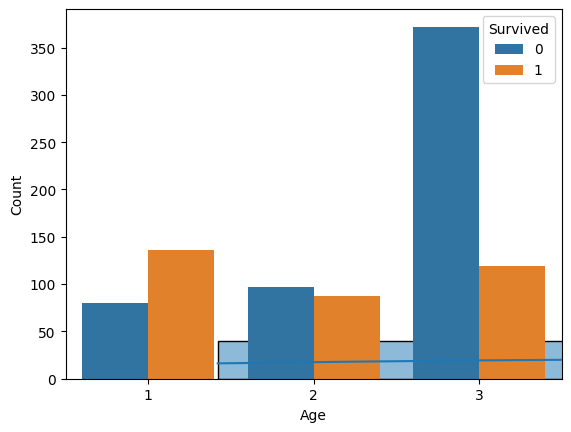

In [8]:
sns.histplot(train["Age"], kde=True)
sns.countplot(x=train["Pclass"], hue=train["Survived"])

Gestion des valeurs manquantes :
On remplit l'âge manquant par la médiane
On remplit la variable 'Embarked' manquante par la valeur la plus fréquente
Remarque : nous n'utilisons pas inplace=True pour éviter les warnings futurs de pandas

In [10]:
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode()[0])

On sélectionne uniquement les colonnes utiles pour prédire la survie.
Ici, les variables choisies sont : Pclass, Sex, Age, SibSp, Fare, Embarked

In [11]:
features = ["Pclass", "Sex", "Age", "SibSp", "Fare", "Embarked"]
X = train[features]
y = train["Survived"]

Les colonnes catégorielles sont encodées avec OneHotEncoder
Les colonnes numériques sont conservées telles quelles
Pipeline : préprocessing + RandomForestClassifier

In [12]:
categorical = ["Sex", "Embarked"]
numeric = ["Pclass", "Age", "SibSp", "Fare"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numeric)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

Séparation du dataset train en train/validation pour évaluer le modèle
20% des données sont utilisées pour validation

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


On prédit sur le jeu de validation et on évalue la performance du modèle
Metrics : accuracy et rapport complet

In [15]:
pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, pred))
print(classification_report(y_val, pred))

Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



On peut visualiser l'importance de chaque feature pour comprendre quelles variables influencent le plus la survie

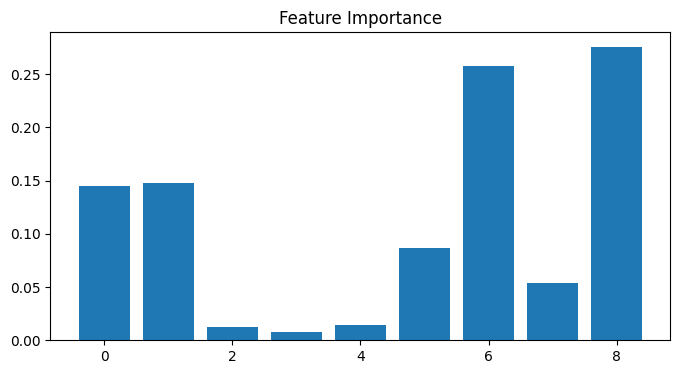

In [16]:
classifier = model.named_steps["classifier"]
importances = classifier.feature_importances_

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.show()

On applique le même preprocessing sur le test set et on génère le fichier submission.csv

In [18]:
test["Age"] = test["Age"].fillna(train["Age"].median())
test["Fare"] = test["Fare"].fillna(train["Fare"].median())

X_test = test[features]

final_pred = model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": final_pred.astype(int) 
})

submission.to_csv("submission.csv", index=False)
print("Fichier submission.csv généré")

Fichier submission.csv généré
